# Hierarchical

## Setup 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns

import os
os.environ["OMP_NUM_THREADS"] = "8"

from sklearn.metrics import *
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.neighbors import kneighbors_graph
from kneed import KneeLocator

In [2]:
#scaling, normalization
from sklearn.preprocessing import StandardScaler, MinMaxScaler

#kmeans, dbscan, hierarchical (sklearn)
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
#evaluation
from sklearn.metrics import silhouette_score

#distance matrix (dbscan elbow, hierarchical)
from scipy.spatial.distance import pdist, squareform

# hierarchical (scipy)
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

In [3]:
df = pd.read_csv("train_cleaned.csv")

In [4]:
df = df.replace({"explicit": {False:0, True:1}})

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   name              15000 non-null  object 
 1   duration_ms       15000 non-null  int64  
 2   explicit          15000 non-null  int64  
 3   popularity        15000 non-null  int64  
 4   artists           15000 non-null  object 
 5   album_name        15000 non-null  object 
 6   danceability      15000 non-null  float64
 7   energy            15000 non-null  float64
 8   key               15000 non-null  int64  
 9   loudness          15000 non-null  float64
 10  speechiness       15000 non-null  float64
 11  acousticness      15000 non-null  float64
 12  instrumentalness  15000 non-null  float64
 13  liveness          15000 non-null  float64
 14  valence           15000 non-null  float64
 15  tempo             15000 non-null  float64
 16  time_signature    15000 non-null  float6

In [6]:
nostrings = df.drop(columns = ['name','artists', 'explicit','album_name','genre'])

In [7]:
nostrings

,duration_ms,popularity,danceability,energy,key,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
0,241760,46,0.690,0.513,5,-12.529,0.0975,0.302000,0.536000,0.2810,0.6350,142.221,4.0
1,444000,0,0.069,0.196,1,-24.801,0.0805,0.283000,0.934000,0.3600,0.0336,75.596,4.0
2,333506,3,0.363,0.854,2,-7.445,0.0397,0.000089,0.800000,0.2620,0.4890,116.628,4.0
3,269800,23,0.523,0.585,5,-5.607,0.0765,0.066400,0.001270,0.1170,0.3850,140.880,4.0
4,307651,25,0.643,0.687,7,-11.340,0.0539,0.000576,0.096900,0.2990,0.6370,143.956,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
14995,432026,0,0.554,0.657,1,-14.232,0.0558,0.016000,0.615000,0.1320,0.0335,117.319,4.0
14996,182746,44,0.103,0.860,1,-19.627,0.0595,0.548000,0.940000,0.1230,0.0016,92.323,3.0
14997,400091,43,0.799,0.535,1,-9.103,0.0594,0.001830,0.857000,0.0713,0.0708,126.000,4.0
14998,197250,37,0.511,0.970,5,-2.299,0.0531,0.000337,0.000014,0.4020,0.2700,160.044,4.0


In [8]:
X = nostrings.values

### MinMax

In [9]:
scaler = MinMaxScaler()
X_minmax = scaler.fit_transform(X)

### Hierarchical

In [10]:
def get_linkage_matrix(model):
    # Create linkage matrix 
    
    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    return linkage_matrix

def plot_dendrogram(model, **kwargs):
    linkage_matrix = get_linkage_matrix(model)
    dendrogram(linkage_matrix, **kwargs)

In [11]:
# setting distance_threshold=0 ensures we compute the full tree.
# it is the linkage distance threshold above which clusters will not be merged
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None, metric='euclidean', linkage='complete')
model = model.fit(X_minmax)

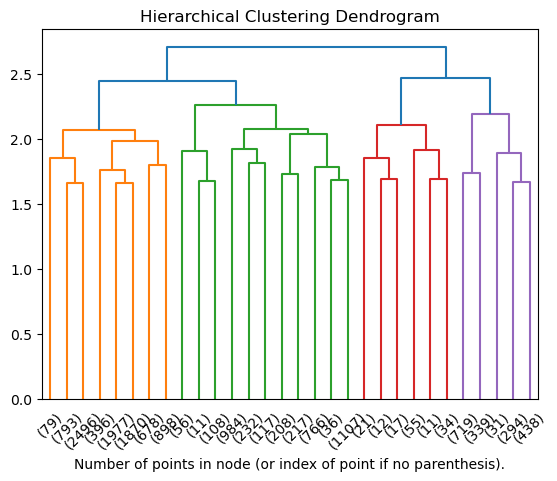

In [12]:
plt.title("Hierarchical Clustering Dendrogram")
plot_dendrogram(model, truncate_mode='lastp', color_threshold=2.4)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

In [13]:
# get the labels according to a specific threshold value cut
Z = get_linkage_matrix(model)
labels = fcluster(Z, t=2.4, criterion='distance')

In [14]:
labels

array([1, 2, 2, ..., 2, 1, 1], dtype=int32)

In [15]:
np.unique(labels, return_counts=True)

(array([1, 2, 3, 4], dtype=int32),
 array([9187, 3842,  150, 1821], dtype=int64))

In [16]:
print('Silhouette', silhouette_score(X_minmax, labels))

Silhouette 0.21702648682536638


#### Choosing the number of clusters

In [17]:
hier = AgglomerativeClustering(n_clusters=4, metric='euclidean', linkage='complete')
hier.fit(X_minmax)

AgglomerativeClustering(linkage='complete', metric='euclidean', n_clusters=4)

In [18]:
hier.labels_

array([3, 0, 0, ..., 0, 3, 3], dtype=int64)

In [19]:
np.unique(hier.labels_, return_counts=True)

(array([0, 1, 2, 3], dtype=int64),
 array([3842, 1821,  150, 9187], dtype=int64))

In [20]:
dist = pdist(X_minmax, 'euclidean')
dist = squareform(dist)

#### Precomputed distance matrix

In [21]:
hier = AgglomerativeClustering(n_clusters=4, metric='precomputed', linkage='complete')
hier.fit(dist)

AgglomerativeClustering(linkage='complete', metric='precomputed', n_clusters=4)

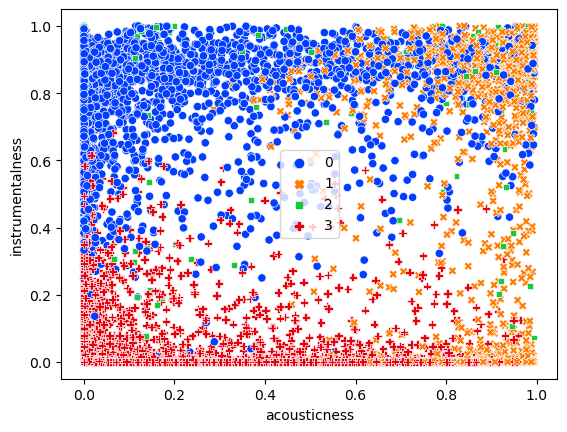

In [22]:
sns.scatterplot(data=df, 
                x="acousticness", 
                y="instrumentalness", 
                hue=hier.labels_, 
                style=hier.labels_, 
                palette="bright")
plt.show()

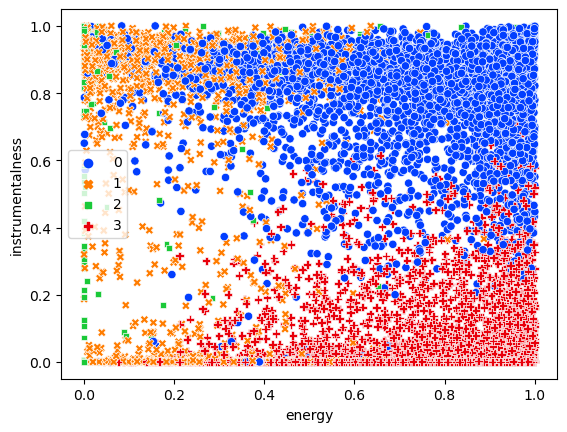

In [23]:
sns.scatterplot(data=df, 
                x="energy", 
                y="instrumentalness", 
                hue=hier.labels_, 
                style=hier.labels_, 
                palette="bright")
plt.show()

In [24]:
np.unique(hier.labels_, return_counts=True)

(array([0, 1, 2, 3], dtype=int64),
 array([3842, 1821,  150, 9187], dtype=int64))

In [25]:
df["labels"] = hier.labels_

sns.pairplot(data=df, hue="labels", palette="bright")
#plt.savefig("pairplot Hier MinMax complete k4.png")
plt.show()

### Ward hierarchical

In [119]:
# hierarchical clustering
# Compute the (weighted) graph of k-Neighbors for points in X
connectivity = kneighbors_graph(X_minmax, n_neighbors=50, include_self=False)

In [120]:
# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(distance_threshold=0, 
                                n_clusters=None, 
                                metric='euclidean', 
                                linkage='complete', 
                                connectivity=None)
                                
# connecet: Defines for each sample the neighboring 
# samples following a given structure of the data.

model = model.fit(X_minmax)

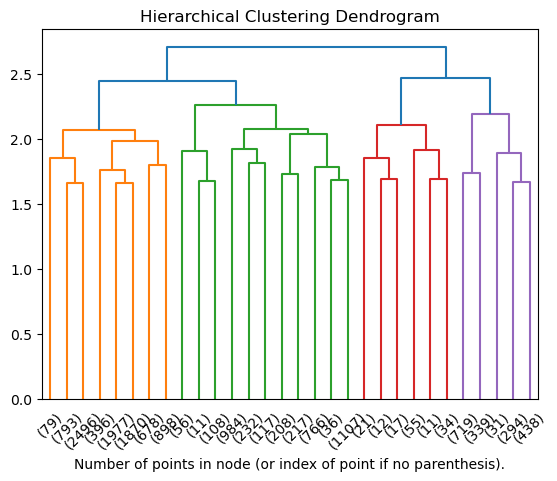

In [121]:
plt.title("Hierarchical Clustering Dendrogram")
plot_dendrogram(model, truncate_mode="lastp", color_threshold=2.35)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

In [122]:
# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(n_clusters=4, 
                                metric='euclidean', 
                                linkage='complete', 
                                connectivity=None)
                                
# connecet: Defines for each sample the neighboring 
# samples following a given structure of the data.

model = model.fit(X_minmax)

hist, bins = np.histogram(model.labels_, bins=range(0, len(set(model.labels_)) + 1))
print('labels', dict(zip(bins, hist)))
print('silhouette', silhouette_score(X_minmax, model.labels_))

labels {0: 3842, 1: 1821, 2: 150, 3: 9187}
silhouette 0.21702648682536638


In [123]:
# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(distance_threshold=0, 
                                n_clusters=None, 
                                metric='euclidean', 
                                linkage='complete', 
                                connectivity=connectivity)
                                
# connecet: Defines for each sample the neighboring 
# samples following a given structure of the data.

model = model.fit(X_minmax)

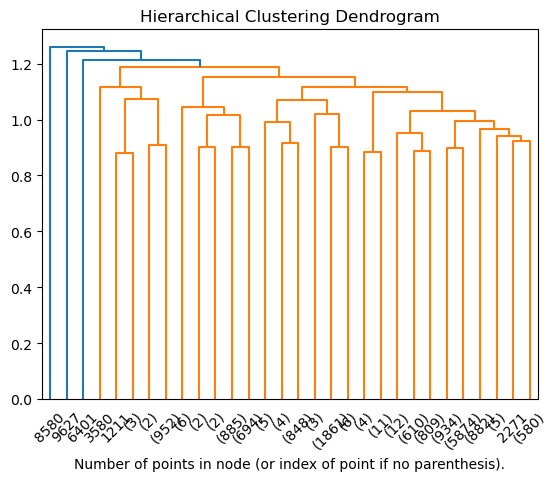

In [124]:
plt.title("Hierarchical Clustering Dendrogram")
plot_dendrogram(model, truncate_mode="lastp", color_threshold=1.19)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

In [125]:
# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(n_clusters=2, 
                                metric='euclidean', 
                                linkage='complete', 
                                connectivity=connectivity)
                                
# connecet: Defines for each sample the neighboring 
# samples following a given structure of the data.

model = model.fit(X_minmax)

hist, bins = np.histogram(model.labels_, bins=range(0, len(set(model.labels_)) + 1))
print('labels', dict(zip(bins, hist)))
print('silhouette', silhouette_score(X_minmax, model.labels_))

labels {0: 14999, 1: 1}
silhouette 0.4353614523475201


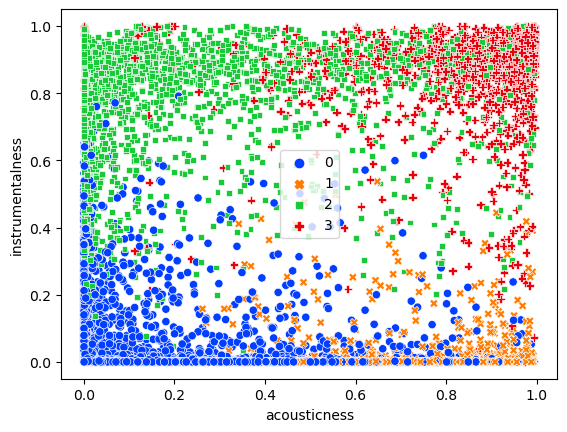

In [126]:
sns.scatterplot(data=df, 
                x="acousticness", 
                y="instrumentalness", 
                hue=ward.labels_, 
                style=ward.labels_, 
                palette="bright")
plt.show()

In [127]:
ward = AgglomerativeClustering(n_clusters=4, 
                               linkage='ward', 
                               metric='euclidean',
                               connectivity=None)
ward.fit(X_minmax)

hist, bins = np.histogram(ward.labels_, bins=range(0, len(set(ward.labels_)) + 1))
print('labels', dict(zip(bins, hist)))
print('silhouette', silhouette_score(X_minmax, ward.labels_))

labels {0: 8093, 1: 1817, 2: 3777, 3: 1313}
silhouette 0.17728307003084207


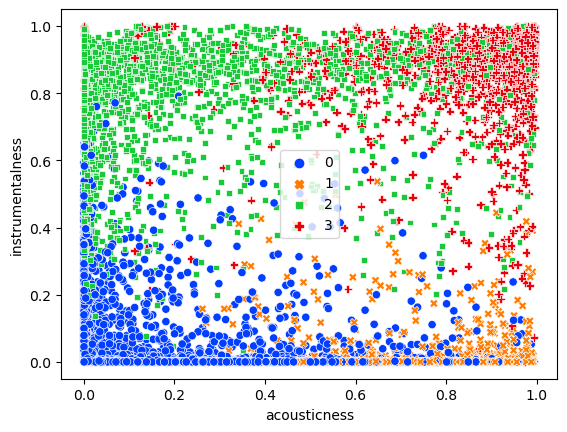

In [35]:
sns.scatterplot(data=df, 
                x="acousticness", 
                y="instrumentalness", 
                hue=ward.labels_, 
                style=ward.labels_, 
                palette="bright")
plt.show()

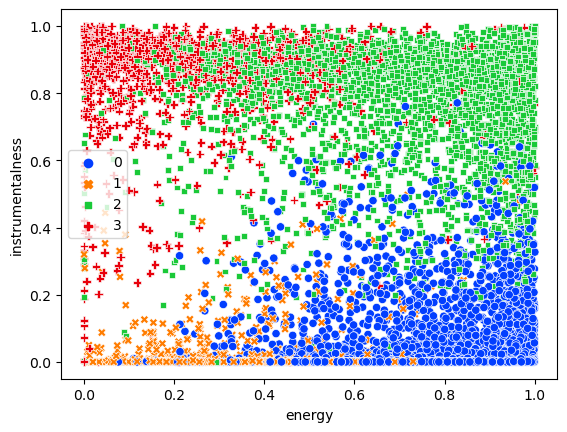

In [36]:
sns.scatterplot(data=df, 
                x="energy", 
                y="instrumentalness", 
                hue=ward.labels_, 
                style=ward.labels_, 
                palette="bright")
plt.show()

In [37]:
Z = get_linkage_matrix(model)
labels = fcluster(Z, t=43, criterion='distance')

In [38]:
df["labels"] = ward.labels_

sns.pairplot(data=df, hue="labels", palette="bright")
#plt.savefig("pairplot Hier MinMax Ward.png")
plt.show()

### Subsetting

#### Cluster label 0

In [39]:
cluster0 = df[df["labels"] == 0]
cluster0.head()

,name,duration_ms,explicit,popularity,artists,album_name,danceability,energy,key,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,genre,labels
3,Can't Look Away,269800,0,23,The Wood Brothers,One Drop of Truth,0.523,0.585,5,-5.607,0.0765,0.066400,0.001270,0.1170,0.385,140.880,4.0,bluegrass,0
4,Thunderground,307651,0,25,The Darkraver;DJ Vince,Happy Hardcore Top 100,0.643,0.687,7,-11.340,0.0539,0.000576,0.096900,0.2990,0.637,143.956,4.0,happy,0
5,Sick Bubblegum,224266,1,32,Rob Zombie,Hellbilly Deluxe 2 (Standard Explicit),0.642,0.972,5,-3.047,0.0967,0.001520,0.000024,0.3840,0.421,118.035,4.0,industrial,0
6,The Diamond Four,225160,0,27,Momoiro Clover Z,MOMOIRO CLOVER Z,0.777,0.949,2,-2.488,0.0585,0.306000,0.000016,0.2990,0.850,109.992,4.0,j-idol,0
7,Quiero tener tu presencia,220626,0,64,Seguridad Social,Furia Latina,0.741,0.816,4,-5.597,0.0797,0.021100,0.000000,0.0981,0.574,146.075,4.0,spanish,0


In [40]:
# Create a dictionary to map colors to values
colors = ['blue']

#sns.pairplot(data=cluster0, hue= 'kmeans.labels_', palette=colors)
#plt.savefig("ppk0 MinMax.png")
#plt.show()

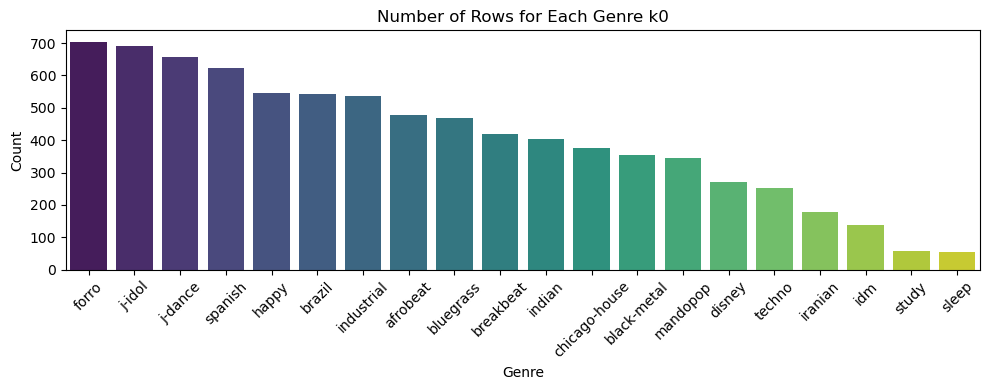

In [41]:
genre_counts = cluster0['genre'].value_counts()

# Plotting the bar plot using Seaborn
plt.figure(figsize=(10, 4))  # Adjust the figure size as needed
sns.barplot(x=genre_counts.index, y=genre_counts.values, palette='viridis')
plt.title('Number of Rows for Each Genre k0')
plt.xlabel('Genre')
plt.ylabel('Count')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability if needed
plt.tight_layout()
#plt.savefig("w0 genre count.png")
plt.show()


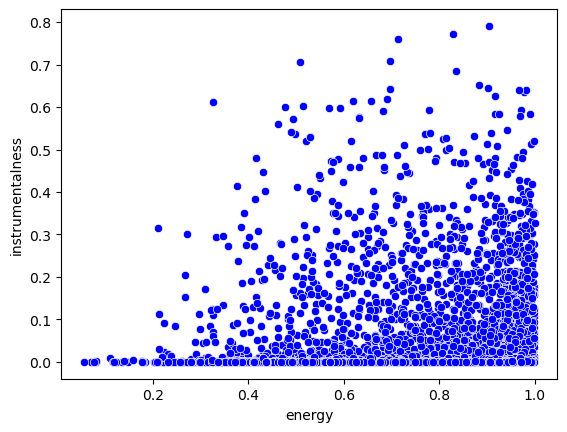

In [42]:
sns.scatterplot(data=cluster0, 
                x="energy", 
                y="instrumentalness", 
                color = 'blue')
#plt.savefig("w0 instr_energy.png")
plt.show()

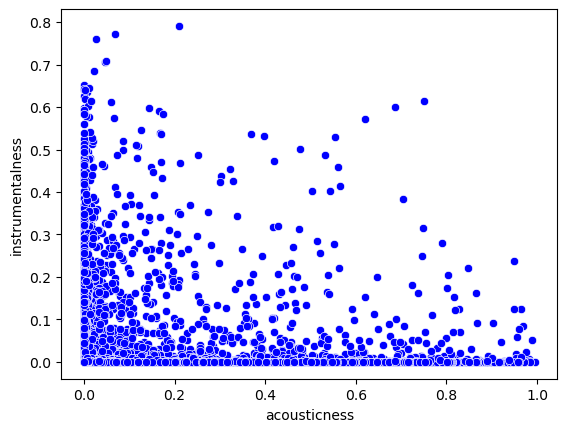

In [43]:
sns.scatterplot(data=cluster0, 
                x="acousticness", 
                y="instrumentalness", 
                color="blue",
               )
#plt.savefig("w0 instr_acous.png")
plt.show()

<Axes: xlabel='loudness', ylabel='instrumentalness'>

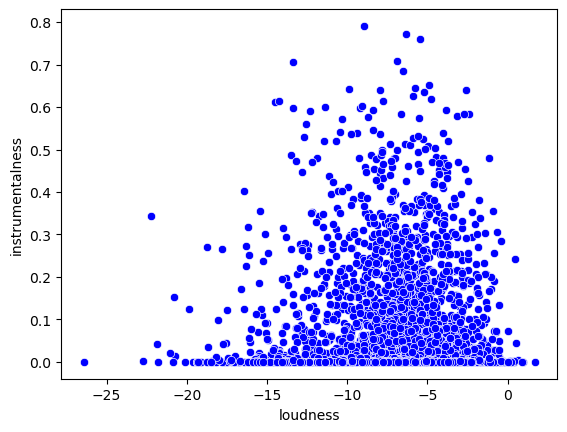

In [44]:
sns.scatterplot(data=cluster0, 
                x="loudness", 
                y="instrumentalness", 
                color="blue",
               )
#plt.savefig("w0 instr_loud.png")
#plt.show()

#### Cluster label 1

In [45]:
cluster1 = df[df["labels"] == 1]
#cluster1 = cluster1.drop('kmeans.labels_std', axis = 1)
cluster1.head()

,name,duration_ms,explicit,popularity,artists,album_name,danceability,energy,key,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,genre,labels
13,知足,256692,0,51,Mayday,知足 just my pride 最真傑作選,0.406,0.230,4,-9.007,0.0297,0.880,0.000000,0.1070,0.395,159.914,4.0,mandopop,1
42,Filho de Davi,353986,0,49,Tony Allysson,Poderoso Deus,0.578,0.635,2,-5.335,0.0278,0.661,0.000000,0.1380,0.343,137.980,4.0,brazil,1
45,Ajab Adaayein,194245,0,46,Swattrex,Ajab Adaayein,0.667,0.193,4,-17.939,0.0316,0.867,0.000222,0.1080,0.307,90.770,4.0,indian,1
52,The Potters Hand,256093,0,43,Hillsong Worship,Ultimate Worship Vol 1,0.301,0.456,7,-6.606,0.0259,0.340,0.000002,0.2050,0.193,74.590,4.0,iranian,1
60,For Those Tears I Died,181760,0,37,The Isaacs,The Living Years,0.422,0.117,11,-13.659,0.0315,0.901,0.000000,0.0546,0.231,77.202,4.0,bluegrass,1


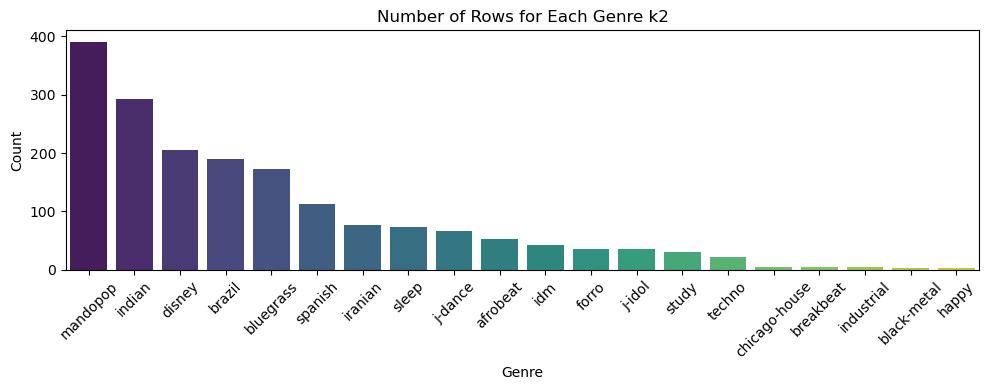

In [46]:
genre_counts = cluster1['genre'].value_counts()

# Plotting the bar plot using Seaborn
plt.figure(figsize=(10, 4))  # Adjust the figure size as needed
sns.barplot(x=genre_counts.index, y=genre_counts.values, palette='viridis')
plt.title('Number of Rows for Each Genre k2')
plt.xlabel('Genre')
plt.ylabel('Count')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability if needed
plt.tight_layout()
#plt.savefig("w1 genre count.png")
plt.show()

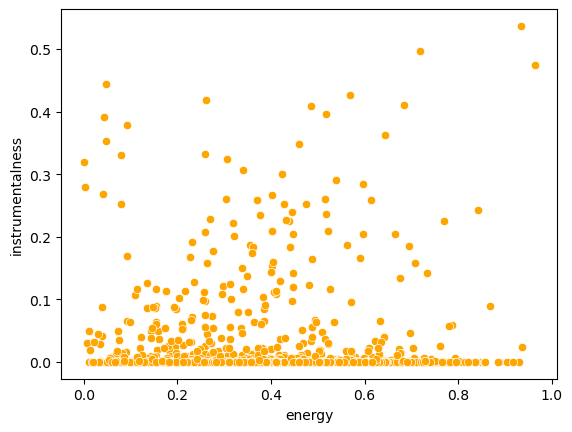

In [47]:
sns.scatterplot(data=cluster1, 
                x="energy", 
                y="instrumentalness", 
                color= 'orange')
#plt.savefig("w1 instr_energy.png")
plt.show()


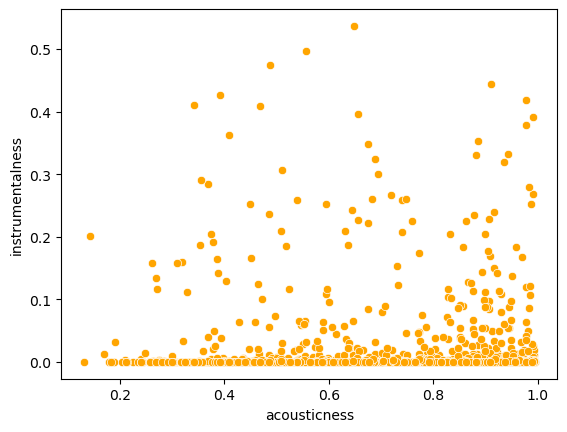

In [48]:
sns.scatterplot(data=cluster1, 
                x="acousticness", 
                y="instrumentalness", 
                color="orange",
               )
#plt.savefig("w1 instr_acous.png")
plt.show()

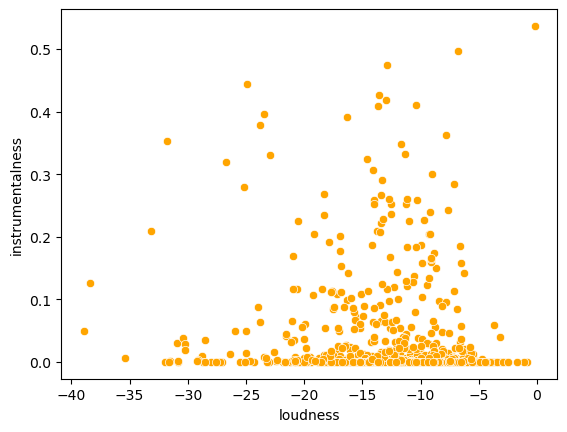

In [49]:
sns.scatterplot(data=cluster1, 
                x="loudness", 
                y="instrumentalness", 
                color="orange",
               )
#plt.savefig("w1 instr_loud.png")
plt.show()

In [50]:
# Create a dictionary to map colors to values
colors = ['orange']

#sns.pairplot(data=cluster1, hue= 'kmeans.labels_', palette=colors)
#plt.savefig("k1 MinMax.png")
#plt.show()

#### cluster label 2

In [51]:
cluster2 = df[df["labels"] == 2]
#cluster2 = cluster2.drop('kmeans.labels_std', axis = 1)
cluster2.head()

,name,duration_ms,explicit,popularity,artists,album_name,danceability,energy,key,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,genre,labels
0,Long Road,241760,0,46,Funki Porcini,Hed Phone Sex,0.690,0.513,5,-12.529,0.0975,0.302000,0.536,0.2810,0.6350,142.221,4.0,j-dance,2
1,"Daniâl My Son, Where Did You Vanish?",444000,0,0,Siavash Amini,A Trail of Laughters,0.069,0.196,1,-24.801,0.0805,0.283000,0.934,0.3600,0.0336,75.596,4.0,iranian,2
2,Ondskapens Galakse,333506,0,3,Kvelertak,Nattesferd,0.363,0.854,2,-7.445,0.0397,0.000089,0.800,0.2620,0.4890,116.628,4.0,black-metal,2
10,Gammy Elbow - VIP Mix,191296,0,19,DJ Zinc;Chris Lorenzo,Gammy Elbow (VIP Mix),0.924,0.893,7,-2.567,0.1910,0.016600,0.859,0.0907,0.6130,129.999,4.0,j-dance,2
11,Nobody Supposed to Be Here,99526,0,21,Kyle Edwards;DJ Smallz 732,Warning,0.885,0.750,6,-8.859,0.1730,0.087800,0.963,0.0453,0.4060,140.079,4.0,techno,2


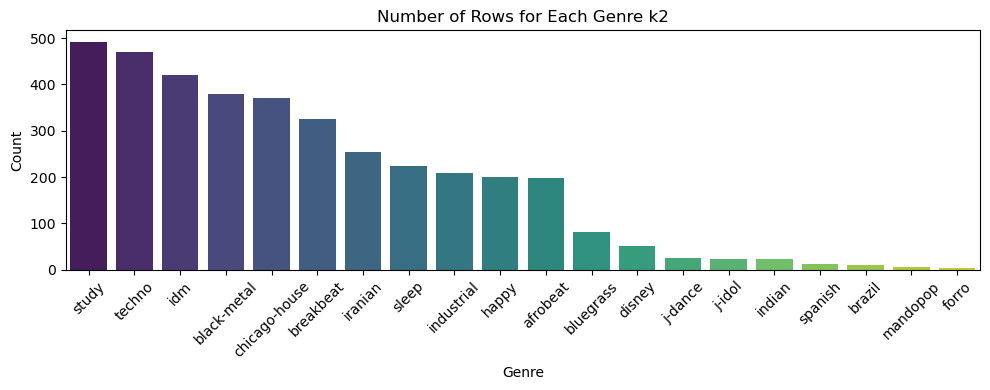

In [52]:
genre_counts = cluster2['genre'].value_counts()

# Plotting the bar plot using Seaborn
plt.figure(figsize=(10, 4))  # Adjust the figure size as needed
sns.barplot(x=genre_counts.index, y=genre_counts.values, palette='viridis')
plt.title('Number of Rows for Each Genre k2')
plt.xlabel('Genre')
plt.ylabel('Count')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability if needed
plt.tight_layout()
#plt.savefig("w2 genre count.png")
plt.show()

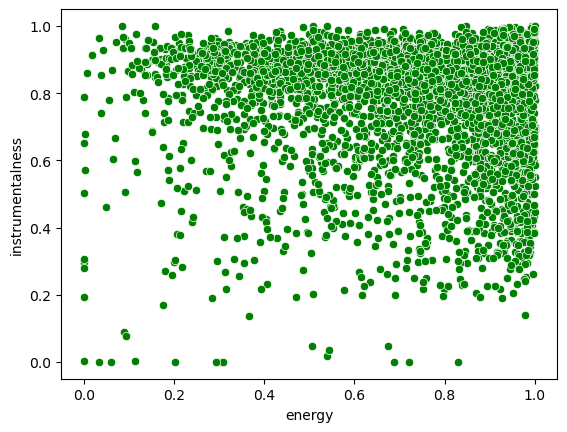

In [53]:
sns.scatterplot(data=cluster2, 
                x="energy", 
                y="instrumentalness", 
                color="green",
               )
#plt.savefig("w2 instr_energy.png")
plt.show()

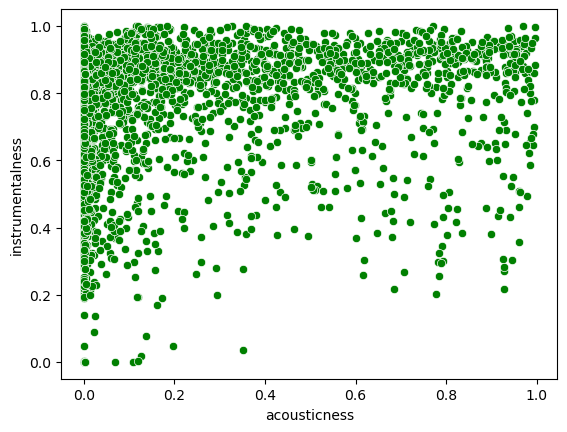

In [54]:
sns.scatterplot(data=cluster2, 
                x="acousticness", 
                y="instrumentalness", 
                color="green",
               )
#plt.savefig("w2 instr_acous.png")
plt.show()

<Axes: xlabel='loudness', ylabel='instrumentalness'>

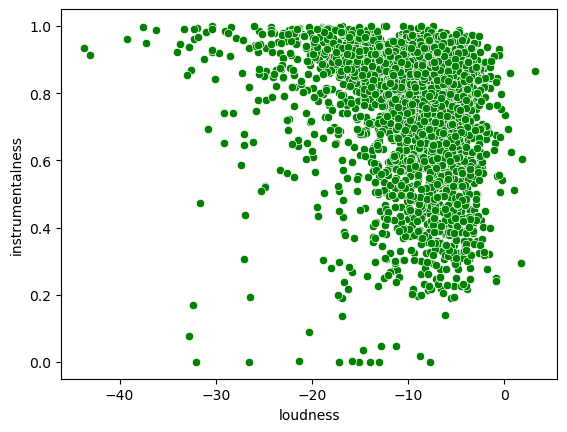

In [55]:
sns.scatterplot(data=cluster2, 
                x="loudness", 
                y="instrumentalness", 
                color="green",
               )
#plt.savefig("w2 instr_loud.png")
#plt.show()

In [56]:
# Create a dictionary to map colors to values
colors = ['green']

#sns.pairplot(data=cluster2, hue= 'kmeans.labels_', palette=colors)
#plt.savefig("k2 MinMax.png")
#plt.show()

#### cluster label 3

In [57]:
cluster3 = df[df["labels"] == 3]
#cluster2 = cluster2.drop('kmeans.labels_std', axis = 1)
cluster3.head()

,name,duration_ms,explicit,popularity,artists,album_name,danceability,energy,key,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,genre,labels
8,Shhhh Baby Shusher Mama Shushing Background Fa...,116815,0,45,Baby Sleep;Baby Shushing;Dreams of Dreams,Shhhh Baby Shusher Mama Shushing Background Fa...,0.153,0.11900,6,-25.160,0.0501,0.704,0.913,0.5430,0.0342,84.886,4.0,sleep,3
16,Querencia,194648,0,57,Cameron Sinosa,Querencia,0.170,0.00316,5,-38.615,0.0422,0.991,0.931,0.1110,0.0946,70.964,3.0,sleep,3
29,never had,140487,0,12,Organ Tapes,唱着那无人问津的歌谣 / Chang Zhe Na Wu Ren Wen Jin De Ge...,0.405,0.38900,2,-14.809,0.0419,0.863,0.720,0.1340,0.7480,89.271,4.0,techno,3
51,Des fissures apparaissent,82746,0,25,Germaine Franco,Encanto: La fantastique famille Madrigal (Band...,0.198,0.48300,1,-14.552,0.0506,0.831,0.927,0.0979,0.2340,76.592,3.0,disney,3
61,Acending,174748,0,58,So Jao,Acending,0.205,0.04060,5,-30.850,0.0462,0.970,0.979,0.1430,0.0592,87.113,3.0,sleep,3


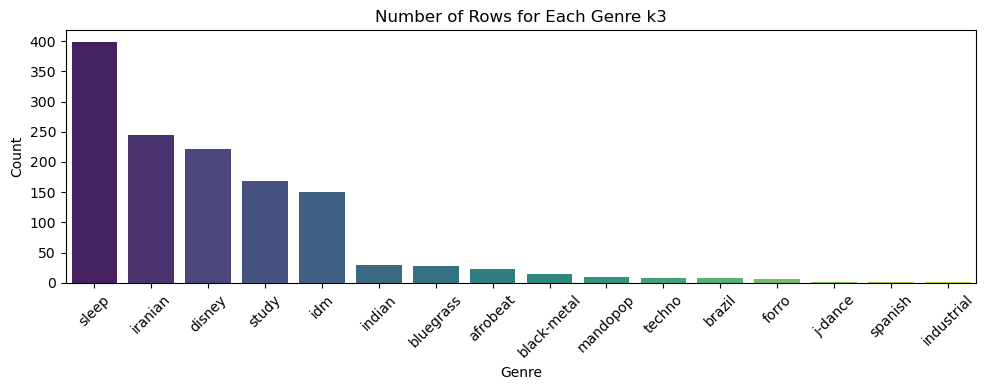

In [58]:
genre_counts = cluster3['genre'].value_counts()

# Plotting the bar plot using Seaborn
plt.figure(figsize=(10, 4))  # Adjust the figure size as needed
sns.barplot(x=genre_counts.index, y=genre_counts.values, palette='viridis')
plt.title('Number of Rows for Each Genre k3')
plt.xlabel('Genre')
plt.ylabel('Count')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability if needed
plt.tight_layout()
#plt.savefig("w3 genre count.png")
plt.show()

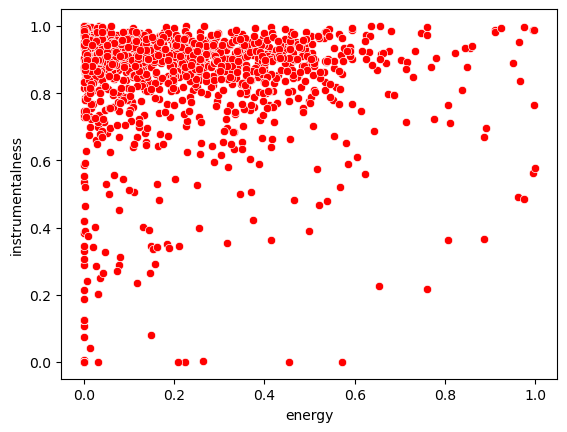

In [59]:
sns.scatterplot(data=cluster3, 
                x="energy", 
                y="instrumentalness", 
                color="red",
               )
#plt.savefig("w3 instr_energy.png")
plt.show()

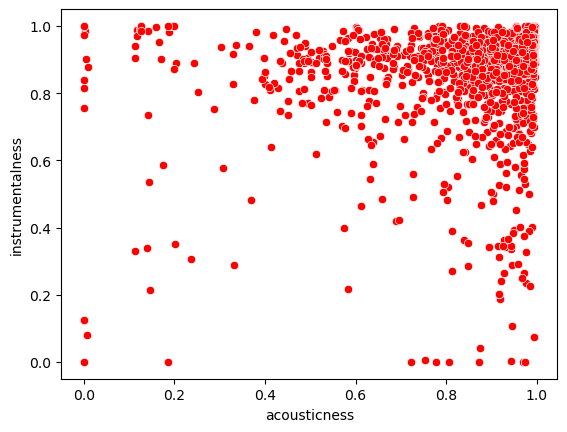

In [60]:
sns.scatterplot(data=cluster3, 
                x="acousticness", 
                y="instrumentalness", 
                color="red",
               )
#plt.savefig("w3 instr_acous.png")
plt.show()

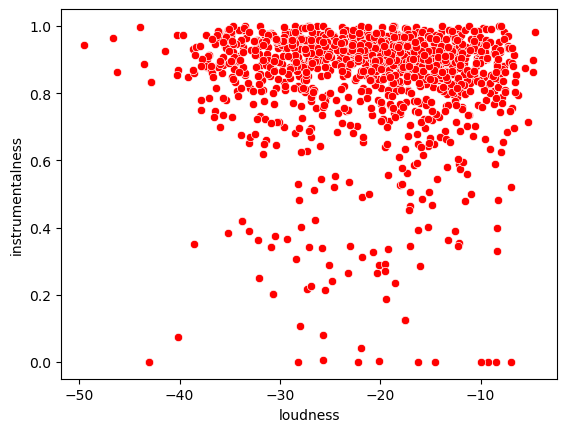

In [61]:
sns.scatterplot(data=cluster3, 
                x="loudness", 
                y="instrumentalness", 
                color="red",
               )
#plt.savefig("w3 instr_loud.png")
plt.show()

In [62]:
# Create a dictionary to map colors to values
colors = ['red']

#sns.pairplot(data=cluster3, hue= 'kmeans.labels_', palette=colors)
#plt.savefig("k2 MinMax.png")
#plt.show()

In [63]:
#cluster0 = df[df["kmeans.labels_"] == 0]
#np.unique(cluster0["genre"],return_counts=True)

In [64]:
# Assuming 'kmeans.labels_' contains the cluster labels in your DataFrame
# Replace 'kmeans.labels_' with the actual column name that stores cluster labels in your DataFrame

# Iterate through clusters 0 to 3
for cluster_num in range(5):  # This will loop through clusters 0 to 3 (total 4 clusters: 0, 1, 2, 3)
    cluster = df[df["labels"] == cluster_num]
    unique_genres, genre_counts = np.unique(cluster["genre"], return_counts=True)
    
    # Sort genres by count in decreasing order
    sorted_indices = np.argsort(genre_counts)[::-1]
    unique_genres_sorted = unique_genres[sorted_indices]
    genre_counts_sorted = genre_counts[sorted_indices]
    
    print(f"Cluster {cluster_num}:")
    for genre, count in zip(unique_genres_sorted, genre_counts_sorted):
        print(f"Genre: {genre}, Count: {count}")
    print("\n")

Cluster 0:
Genre: forro, Count: 704
Genre: j-idol, Count: 690
Genre: j-dance, Count: 656
Genre: spanish, Count: 624
Genre: happy, Count: 546
Genre: brazil, Count: 542
Genre: industrial, Count: 537
Genre: afrobeat, Count: 477
Genre: bluegrass, Count: 469
Genre: breakbeat, Count: 420
Genre: indian, Count: 405
Genre: chicago-house, Count: 375
Genre: black-metal, Count: 353
Genre: mandopop, Count: 345
Genre: disney, Count: 272
Genre: techno, Count: 251
Genre: iranian, Count: 177
Genre: idm, Count: 137
Genre: study, Count: 59
Genre: sleep, Count: 54


Cluster 1:
Genre: mandopop, Count: 391
Genre: indian, Count: 293
Genre: disney, Count: 205
Genre: brazil, Count: 190
Genre: bluegrass, Count: 172
Genre: spanish, Count: 112
Genre: iranian, Count: 76
Genre: sleep, Count: 74
Genre: j-dance, Count: 66
Genre: afrobeat, Count: 52
Genre: idm, Count: 43
Genre: forro, Count: 36
Genre: j-idol, Count: 36
Genre: study, Count: 30
Genre: techno, Count: 21
Genre: chicago-house, Count: 5
Genre: breakbeat, Co

### Average linkage

In [65]:
# hierarchical clustering
# Compute the (weighted) graph of k-Neighbors for points in X
connectivity = kneighbors_graph(X_minmax, n_neighbors=50, include_self=False)

In [66]:
print('average linkage')
average_linkage = AgglomerativeClustering(distance_threshold=0, n_clusters=None, linkage='average', metric='manhattan',  connectivity=connectivity)
average_linkage.fit(X_minmax)

#hist, bins = np.histogram(average_linkage.labels_, bins=range(0, len(set(average_linkage.labels_)) + 1))

#print('labels', dict(zip(bins, hist)))
#print('silhouette', silhouette_score(X_minmax, average_linkage.labels_))

average linkage


AgglomerativeClustering(connectivity=<15000x15000 sparse matrix of type '<class 'numpy.float64'>'
	with 750000 stored elements in Compressed Sparse Row format>,
                        distance_threshold=0, linkage='average',
                        metric='manhattan', n_clusters=None)

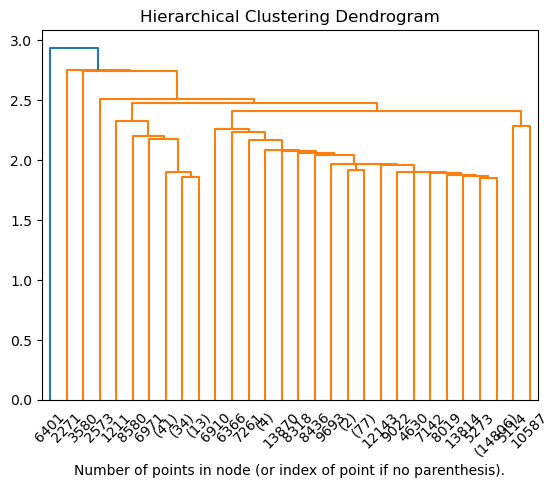

In [67]:
plt.title("Hierarchical Clustering Dendrogram")
plot_dendrogram(average_linkage, truncate_mode='lastp', color_threshold=2.8)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

In [68]:
print('average linkage')
average_linkage = AgglomerativeClustering(n_clusters=2, linkage='average', metric='manhattan',  connectivity=connectivity)
average_linkage.fit(X_minmax)

hist, bins = np.histogram(average_linkage.labels_, bins=range(0, len(set(average_linkage.labels_)) + 1))

print('labels', dict(zip(bins, hist)))
print('silhouette', silhouette_score(X_minmax, average_linkage.labels_))

average linkage
labels {0: 14999, 1: 1}
silhouette 0.3281695758509474


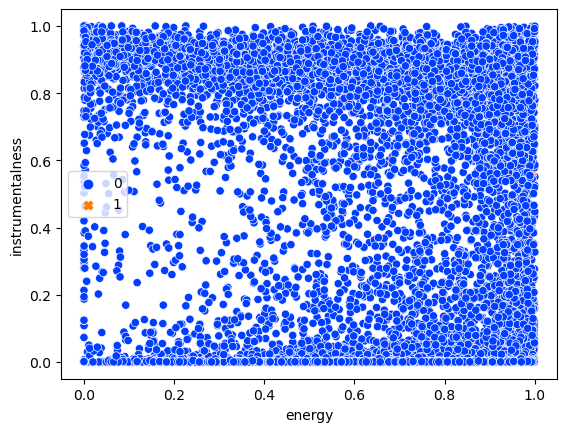

In [69]:
sns.scatterplot(data=df, 
                x="energy", 
                y="instrumentalness", 
                hue=average_linkage.labels_, 
                style=average_linkage.labels_, 
                palette="bright")
plt.show()

### Complete Linkage

In [70]:
print('complete linkage')
complete_linkage = AgglomerativeClustering(distance_threshold=0, n_clusters=None, linkage='complete', metric='manhattan', connectivity=connectivity)
complete_linkage.fit(X_minmax)

#hist, bins = np.histogram(complete_linkage.labels_, bins=range(0, len(set(complete_linkage.labels_)) + 1))

#print('labels', dict(zip(bins, hist)))
#print('silhouette', silhouette_score(X_minmax, complete_linkage.labels_))

complete linkage


AgglomerativeClustering(connectivity=<15000x15000 sparse matrix of type '<class 'numpy.float64'>'
	with 750000 stored elements in Compressed Sparse Row format>,
                        distance_threshold=0, linkage='complete',
                        metric='manhattan', n_clusters=None)

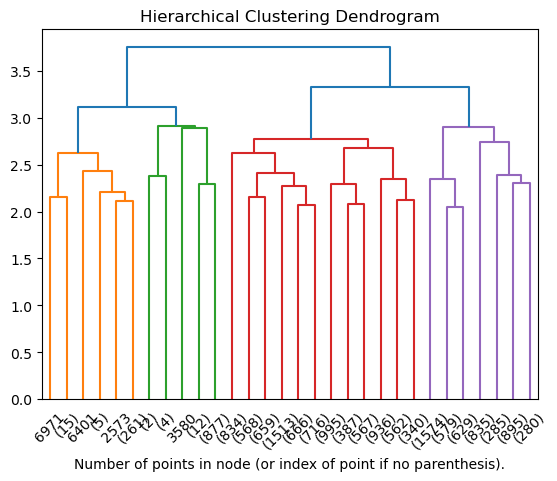

In [71]:
plt.title("Hierarchical Clustering Dendrogram")
plot_dendrogram(complete_linkage, truncate_mode='lastp', color_threshold=3)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

In [72]:
complete_linkage = AgglomerativeClustering(n_clusters=4, linkage='complete', metric='manhattan', connectivity=connectivity)
complete_linkage.fit(X_minmax)

hist, bins = np.histogram(complete_linkage.labels_, bins=range(0, len(set(complete_linkage.labels_)) + 1))

print('labels', dict(zip(bins, hist)))
print('silhouette', silhouette_score(X_minmax, complete_linkage.labels_))

labels {0: 896, 1: 5077, 2: 8743, 3: 284}
silhouette -0.00841656427437369


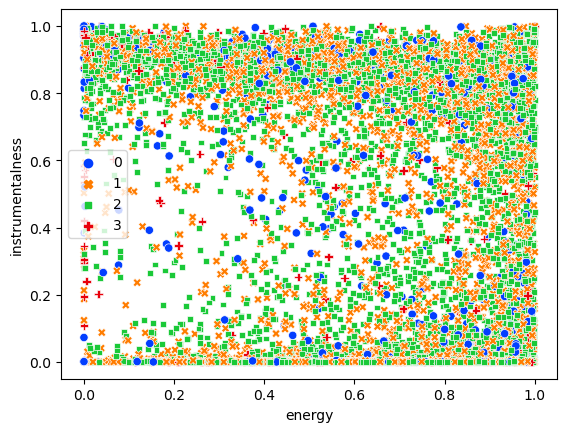

In [73]:
sns.scatterplot(data=df, 
                x="energy", 
                y="instrumentalness", 
                hue=complete_linkage.labels_, 
                style=complete_linkage.labels_, 
                palette="bright")
plt.show()

### Linkage = 'single'

In [74]:
# setting distance_threshold=0 ensures we compute the full tree.
# it is the linkage distance threshold above which clusters will not be merged
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None, 
                                metric='euclidean', linkage='single')
model = model.fit(X_minmax)

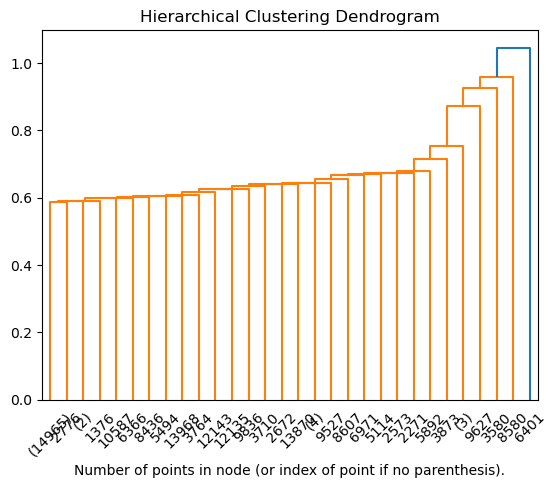

In [75]:
plt.title("Hierarchical Clustering Dendrogram")
plot_dendrogram(model, truncate_mode='lastp', color_threshold=1)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

In [76]:
# get the labels according to a specific threshold value cut
Z = get_linkage_matrix(model)
labels = fcluster(Z, t=1, criterion='distance')

In [77]:
labels

array([1, 1, 1, ..., 1, 1, 1], dtype=int32)

In [78]:
print('Silhouette', silhouette_score(X_minmax, labels))

Silhouette 0.3281695758509474


#### Choosing the number of clusters

In [79]:
hier = AgglomerativeClustering(n_clusters=3, metric='euclidean', linkage='single')
hier.fit(X_minmax)

AgglomerativeClustering(linkage='single', metric='euclidean', n_clusters=3)

In [80]:
hier.labels_

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

#### Precomputed distance matrix

In [81]:
hier = AgglomerativeClustering(n_clusters=3, metric='precomputed', linkage='single')
hier.fit(dist)

AgglomerativeClustering(linkage='single', metric='precomputed', n_clusters=3)

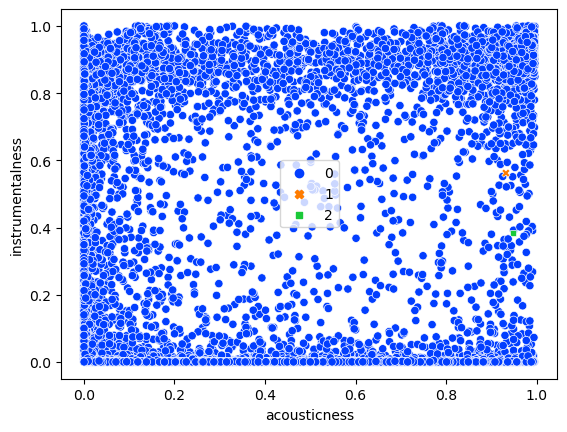

In [82]:
sns.scatterplot(data=df, 
                x="acousticness", 
                y="instrumentalness", 
                hue=hier.labels_, 
                style=hier.labels_, 
                palette="bright")
plt.show()

In [83]:
df["labels"] = hier.labels_

sns.pairplot(data=df, hue="labels", palette="bright")
#plt.savefig("pairplot Hier MinMax single.png")
plt.show()